# Evaluate Autoencoder + Autoencoder + PCA + DBSCAN

** Flow features used:**
* All features which are float/integer type
* Number of features is 31:

[u'src_ip', u'dst_ip', u'ip_protocol', u'traffic_type', u'pkts_cnt', u'min_interarrival_time', u'max_interarrival_time', u'mean_interarrival_time', u'std_dev_interarrival_time', u'bytes_cnt', u'min_packet_length', u'max_packet_length', u'mean_packet_length', u'std_dev_packet_length', u'tcp_flags', u'syn_cnt', u'push_cnt', u'rst_cnt', u'fin_cnt', u'total_datalen', u'min_payload_byte', u'max_payload_byte', u'mean_payload_byte', u'std_dev_payload_byte', u'byte_distribution_entropy', u'src_ip_entropy', u'src_ip_cnt', u'src_port_entropy', u'src_port_cnt', u'dst_port_entropy', u'dst_port_cnt']

Feature `src_ip` contains only two first octets (eg.: "150.254") is converted to `float`.
Features `syn_cnt`, `rst_cnt`, `fin_cnt` are divided by `pkts_cnt` to have each flag ratio in the flow.

**Datasets** from hdfs /data/ddos_example used.
* Datasets collected using 16-bit src IP prefix and skipping src and dst ports information but containing entropy for source IPs, source/destinations ports. 

**Done:**
* Test errors of short DDoS attack period within normal traffic
* Produce False Postives and False Negatives of DDoS flow detection

In [1]:
from hdfs import InsecureClient
from pprint import pprint
import random
import time

import tensorflow as tf
print(tf.__version__)

from multilayerp import MultilayerPerceptron

import dataset_utils2 as ds
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")
%matplotlib inline
%load_ext autoreload
%autoreload 2

1.0.0


In [2]:
def modify_flow(flow):
    for feature in ['syn_cnt', 'push_cnt', 'rst_cnt', 'fin_cnt']:
        if feature in flow:
            new_property = feature.replace('cnt','prop')
            setattr(flow, new_property, 1.0*getattr(flow, feature)/flow.pkts_cnt)
            delattr(flow, feature)
    return flow
                    
def skip_ddos(flow):    
    # skip flows which most probably are DDoS
    for feature in ['syn_cnt', 'rst_cnt', 'fin_cnt']:
        if feature in flow._fields and getattr(flow, feature)/flow.pkts_cnt > 0.8:
            return True

** Create HDSF client and gets all datasets **

In [3]:
hdfs = InsecureClient('http://hs-01.ipa.psnc.pl:50070', timeout=(10,10))

In [4]:
datasets = ds.get_datasets(hdfs, "/data/ddos_examples/2017_Apr_07")
pprint(datasets)

defaultdict(None,
            {'Pozman+RSTflood': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-15-35-16-2017.csv',
             'Pozman+SYNflood-HTTP': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-14-59-08-2017.csv',
             'Pozman+SYNflood-HTTP-2a': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-15-03-45-2017.csv',
             'Pozman+SYNflood-HTTP-2b': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-16-04-11-2017.csv',
             'Pozman+SYNfloodFIN': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-15-07-24-2017.csv',
             'Pozman+SYNfloodRST': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-15-06-08-2017.csv',
             'Pozman-1': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-15-39-53-2017.csv',
             'Pozman-2': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-15-40-12-2017.csv',
             'Pozman-3': '/data/ddos_examples/2017_Apr_07/table-Fri-Apr--7-15-40-29-2017.csv',
             'Pozman-4': '/data/ddos_examples/2017_Apr_07/

** Present example of the flow **

In [5]:
ds.print_dataset_flow(hdfs, datasets)

                    flow_index	66894
            reverse_flow_index	-1
                        src_ip	126.26
                src_ip_country	JP
                   src_ip_city	
                        dst_ip	150.254
                dst_ip_country	PL
                   dst_ip_city	Poznan
                      src_port	0
                      dst_port	0
                   ip_protocol	6
                  traffic_type	192
                          vlan	401
                      pkts_cnt	18
               first_timestamp	3700558745.201289
                last_timestamp	3700558748.1894836
         min_interarrival_time	2272
         max_interarrival_time	570080
        mean_interarrival_time	169525.71
     std_dev_interarrival_time	148154.17
       list_interarrival_times	[570080, 126234, 120247, 33483, 181540, 336400, 107935, 211896, 200602, 123803, 79597, 101038, 425236, 75069, 141251, 2272, 45254]
                     bytes_cnt	1224
             min_packet_length	68
             max_packet_

## Autoencoder over a mix of flow features

** Flow features chosen **

In [6]:
features = ds.get_features_names(hdfs, datasets['Pozman-1'])
to_removal = ['flow_index', 'reverse_flow_index', 'vlan', 'first_timestamp', 'last_timestamp', 'hop_cnt',
              'list_tcp_flags', 'list_packet_length', 'list_interarrival_times', 'src_ip_country',
              'src_ip_city', 'dst_ip_country', 'dst_ip_city', 'src_port', 'dst_port', 
              'src_port_entropy', 'dst_port_entropy', 'src_ip_entropy', 
              'min_interarrival_time', 'max_interarrival_time', 'mean_interarrival_time', 'std_dev_interarrival_time',
              'src_ip', 'dst_ip']
features = [feature for feature in features if feature not in to_removal]

** Prepare Encoder and use it on train datasets **

In [7]:
def train_autoencoder(traindata):
    # Define the size of the neural network
    n_input = len(traindata[0])
    n_hidden_layer = int(len(traindata[0])*0.3)
    print("Input: %i, hidden: %i" % (n_input, n_hidden_layer))
      
    # Build autoencoder neural network graph
    learning_rate = 0.05
    layers = [n_input, n_hidden_layer, n_input]
    activations = [tf.nn.relu, tf.nn.sigmoid]
    autoencoder = MultilayerPerceptron(layers, activations, learning_rate)

    # Launch the graph
    lossdev = autoencoder.train(traindata)
    scoretrain = autoencoder.score(traindata)
    max_scoretrain = max(scoretrain)
    
    plt.figure(figsize=(20,10))
    plt.subplot(2,2,1)
    plt.plot(lossdev, label='loss deviation')
    plt.grid(True)
    plt.legend()
    
    scoretrain2 = ds.movingaverage(scoretrain, window=10)
    threshold_error = max(scoretrain2)

    plt.subplot(2,2,2)
    plt.plot(scoretrain, color='lightblue', label='train error')
    plt.plot(scoretrain2, label='train error')
    plt.axhline(max_scoretrain, color='black', label='max train error')
    plt.axhline(threshold_error, color='brown', label='threshold error')
    plt.legend()
    plt.show()
    
    return autoencoder, threshold_error

** Detect with subnets are source of DDoS attacks and calculate true positives, false positives, true negatives and false negatives**

# Dimenational reduction (PCA) and clustering of AutoEncode outliers

** Graph utils **

In [89]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from matplotlib.pyplot import cm
import matplotlib.patches as mpatches
import random

def plot2D_clusters(data2D, labels):
    if len(data2D) != len(labels):
        print("Data len is %i whereas labels len is %i" % (len(data2D), len(labels)))
        return
    # reduce the size of the computation problem
    if len(data2D) > 10000:
        data2D = data2D[:10000]
        labels = labels[:10000]
        #zipped = random.sample(zip(data2D, labels), 1000)
        #data2D, labels = zip(*zipped)  # unzip
        
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    #print "Number of clusters", n_clusters
    if n_clusters < 10:
        #colors = ['#4EACC5', '#FF9C34', '#4E9A06', '#67C38A', '#A0B032']
        colors = ["#2103c8", "#0e960e", "#e40402","#05aaa8","#ac02ab",
                  "#aba808","#151515","#94a169", "#bec9cd", "#6a6551"]
    else:
        colors = cm.rainbow(np.linspace(0,1,n_clusters))

    # plot data
    plt.xlim([-1.5,1.5])
    plt.ylim([-1.5,1.5])
    for index in range(len(data2D)):
        marker, size = ('^', 3) if labels[index] == -1 else ('.', 50)
        plt.scatter([data2D[index,0]], [data2D[index,1]], color=colors[labels[index]], s=size, 
                marker=marker)
    
    # add Legend with labels
    recs = []
    classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8"]
    classes = classes[:n_clusters]
        
    for i in range(0, n_clusters):
        recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=colors[i]))
    if -1 in labels:
        recs.append(mpatches.Rectangle((0, 0), 1, 1, fc=colors[-1]))
        classes += ["-1"]
    plt.legend(recs, classes)
    
    return n_clusters

** Analize util functions **

In [9]:
def dominating_value(values, no_buckets=1000, name=''):
    '''Find a dominating value within value list'''
    num = len(values)
    if len(set(values)) < 20:
        # asume that values are discrete
        from collections import Counter
        result = Counter(values).most_common(5)
    else:
        # asume that values are continues
        min_value = min(values)
        max_value = max(values)
        
        # set proper value resolution
        if max_value - min_value <= 1.0:
            form = "%.3f-%.3f"
        elif max_value - min_value <= 10.0:
            form = "%.2f-%.2f"
        elif max_value - min_value <= 100.0:
            form = "%.1f-%.1f"
        else:
            form = "%.1f-%.1f"
        
        buckets = [0,]*no_buckets # bucket counters
        buckets_edges = []
        bucket_names = []

        # assign buckets egdes and names
        for i in range(1, no_buckets+1):
            edge_value = min_value+1.0*i*(max_value-min_value)/no_buckets
            buckets_edges.append(edge_value)
            if len(bucket_names) == 0:
                bucket_names.append(form % (min_value, edge_value))
            else:
                bucket_names.append(form % (prev_edge, edge_value))
            prev_edge = edge_value

        # find correct bucket for a value and increameant a bucket
        for value in values:
            for index, edge in enumerate(buckets_edges[1:]):
                if value < edge:
                    buckets[index] += 1
                    break

        # sort by bucket counter values
        result = zip(bucket_names, buckets)
        result = sorted(result, key=lambda item: item[1], reverse=True)

    # return dominating value
    if len(result) == 1:
        # all values in a single bucket
        return str(result[0][0]), 1
    elif len(result) > 1 and 1.0*result[0][1]/num > 0.5 and result[0][1] > 5*result[1][1]:
        # first bucket dominates within values
        return str(result[0][0]), 1.0*result[0][1]/num
    else:
        # no bucket dominates 
        return None

In [10]:
import random
from collections import namedtuple

def search_flows_commons(flows, features):
    '''Analyze each flow features and find those features 
    and feature values which are common for most of the flows'''
    
    # reduce the size of the computation problem
    if len(flows) > 1000:
        flows = random.sample(flows, 1000)
        
    stats = {}
    flow_class = namedtuple("Flow_%i" % len(features), features)
    for flow in flows:
        flow = ds.filter_features(flow, features, flow_class)
        flow = modify_flow(ds.NamedDict(flow))
        
        # initialize stats
        if len(stats) == 0:
            for feature_name in flow.keys():
                stats[feature_name] = []
                
        for feature_name, value in flow.items():
            stats[feature_name].append(value)          

    desc = {}
    for feature_name, values in stats.items():
        result = dominating_value(values, name=feature_name)
        
        # hide not present TCP flags
        if feature_name in ['syn_prop', 'push_prop', 'rst_prop', 'fin_prop']:
            if result and '-' in result[0]:
                result = (float(result[0].split('-')[0]), result[1])
            if result and float(result[0]) == 0.0:
                result = None  
        if result:
            desc[feature_name] = result
    return desc

In [34]:
def analyze_flow_categories(flows, features, cluster_labels, n_clusters):
    '''Analize clustered flows'''
    categories = []
    for i in range(n_clusters):
        categories.append([])
    for index in range(len(flows)):
        category = cluster_labels[index]
        try:
            if category != -1:
                categories[category].append(index)
        except:
            print("Category index is: %i, for flow index: %i" % (category, index))
            print("Number of clusters is: %i" % n_clusters)
            import traceback
            traceback.print_exc()
    
    if len(categories) > 0 and len(categories[-1]) == 0:
        categories = categories[:-1]
        
    def format_counter(counter, n_items=5):
        text = ""
        for item in flag_counter.most_common(n_items):
            text += "%.1f (%i times), " % item
        return text

    ddos_category = []
    for cat_id, category in enumerate(categories):
        print("Category id #%i contains %i flows" % (cat_id, len(category)))
        cluster_desc = search_flows_commons([flows[index] for index in category], features)
        is_ddos = False
        for feature_name, value in cluster_desc.items():
            feature_value, prop = value
            #print("   %30s: %s (%d%%)" % (feature_name, str(feature_value), 100.0*prop))
            if feature_name in ['syn_prop', 'rst_prop', 'fin_prop']:
                if float(feature_value) > 0.8:
                    is_ddos = True
        ddos_category.append(is_ddos)
        
    return categories, ddos_category

In [48]:
pca = None
def cluster2D_and_analyze_flows(flows, features, gen_graphs=True):
    flow_data, _features = ds.prepare_data(flows, features, flow_modification_f=modify_flow)
    print("Number of flow clustered:", len(flow_data))
    
    # make 2D PCA
    global pca
    if not pca:
        pca = PCA(n_components=2)
        pca.fit(flow_data)
    pca_data2 = pca.transform(flow_data)
    
    print("PCA 2D dimentions variances:", pca.explained_variance_ratio_)
    
    # make DBSCAN on initial set of 2D data
    dbscan_flow_length = 10000 if len(flows) <= 10000 else 10000 
    db = DBSCAN(eps=0.2, min_samples=10).fit(pca_data2[:dbscan_flow_length])
    labels = db.labels_
    labels_set = set(labels)
    labels_set.discard(-1)
    n_clusters = len(labels_set) # don't count '-1' as a cluster
    print(n_clusters)
    if gen_graphs:
        plt.figure(figsize=(15,8))
        plt.subplot(2,2,1)
        plot2D_clusters(pca_data2[:dbscan_flow_length], labels)
        plt.title('Flows data clustered using DBSCAN')
        plt.show()
            
    # make futher analyze on
    flow_categories, ddos_category = analyze_flow_categories(flows[:dbscan_flow_length], features, labels, n_clusters)
    return flow_categories, ddos_category, pca_data2

## Perform analyzes 

** Prepare train datasets for first Autoencoder basing on a set of normal POZMAN traffic **

In [13]:
files = [datasets['Pozman-%i'%i] for i in range(1, 6)]

traindata, _features, borders = ds.prepare_datasets(hdfs, files, features, shuffle=True, 
                                           flow_modification_f=modify_flow, 
                                           skip_flow_f=skip_ddos)
print("Flow features are [%i]: %s" % (len(_features), _features))

Skipped flows: 5720 from 31857 (17.96%)
Skipped flows: 5729 from 30943 (18.51%)
Skipped flows: 5676 from 31137 (18.23%)
Skipped flows: 5943 from 31401 (18.93%)
Skipped flows: 5902 from 30911 (19.09%)
Flow features are [22]: ('mean_packet_length', 'total_datalen', 'std_dev_payload_byte', 'tcp_flags', 'ip_protocol', 'dst_port_cnt', 'pkts_cnt', 'syn_prop', 'src_ip_cnt', 'src_port_cnt', 'max_packet_length', 'rst_prop', 'push_prop', 'min_packet_length', 'std_dev_packet_length', 'bytes_cnt', 'max_payload_byte', 'mean_payload_byte', 'min_payload_byte', 'byte_distribution_entropy', 'traffic_type', 'fin_prop')


Input: 22, hidden: 6
...................................................................................................

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


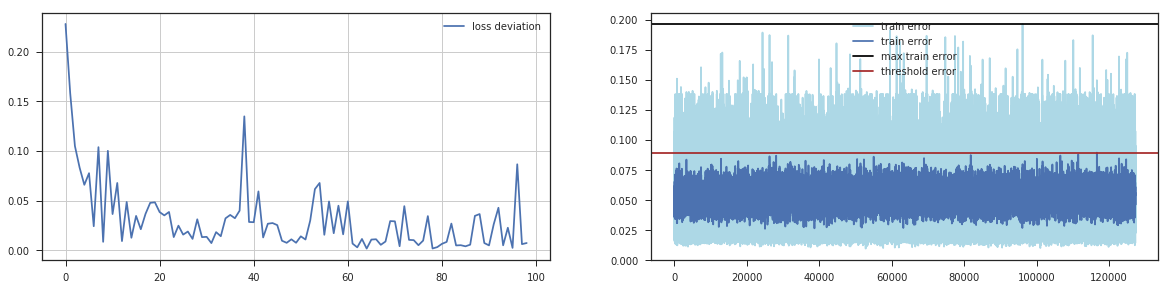

In [14]:
autoencoder, threshold_error = train_autoencoder(traindata)

In [15]:
datasets2 = ds.get_datasets(hdfs, "/data/damianp/aggr_flows_pozman")
pprint(datasets2)

defaultdict(None,
            {0: '/data/damianp/aggr_flows_pozman/table-Mon-Jul-17-15-13-54-2017.csv',
             1: '/data/damianp/aggr_flows_pozman/table-Mon-Jul-17-15-50-58-2017.csv',
             2: '/data/damianp/aggr_flows_pozman/table-Thu-Jul-20-09-13-34-2017.csv',
             3: '/data/damianp/aggr_flows_pozman/table-Thu-Jul-20-10-50-30-2017.csv',
             4: '/data/damianp/aggr_flows_pozman/table-Thu-Jul-20-12-12-39-2017.csv',
             5: '/data/damianp/aggr_flows_pozman/table-Thu-Jul-20-13-06-52-2017.csv',
             6: '/data/damianp/aggr_flows_pozman/table-Tue-Jul-18-07-31-16-2017.csv',
             7: '/data/damianp/aggr_flows_pozman/table-Tue-Jul-18-08-16-15-2017.csv',
             8: '/data/damianp/aggr_flows_pozman/table-Tue-Jul-18-09-23-35-2017.csv',
             9: '/data/damianp/aggr_flows_pozman/table-Tue-Jul-18-10-16-55-2017.csv',
             10: '/data/damianp/aggr_flows_pozman/table-Tue-Jul-18-11-20-17-2017.csv',
             11: '/data/damianp/agg

** Prepare train datasets for second Autoencoder basing on a set of normal POZMAN traffic **

In [16]:
def detect_above_threshold(hdfs, traffic, features, autoencoder, gen_graphs=True):
    print("Analysing traffic:", traffic)
    
    flows = list(ds.get_flows(hdfs, datasets2[traffic]))
    _testdata, _features = ds.prepare_data(flows, features, flow_modification_f=modify_flow)
    _scoretest = autoencoder.score(_testdata)
    
    flows_above_threshold = [flow for flow, score in zip(flows, _scoretest) if score > threshold_error]
    return flows_above_threshold

In [17]:
flows_above_threshold = []
for name, dataset in datasets2.items():
    result = detect_above_threshold(hdfs, name, features, autoencoder, gen_graphs=False)
    flows_above_threshold += result

Analysing traffic: 0
Skipped flows: 0 from 29168 (0.00%)
Analysing traffic: 1
Skipped flows: 0 from 25478 (0.00%)
Analysing traffic: 2
Skipped flows: 0 from 28006 (0.00%)
Analysing traffic: 3
Skipped flows: 0 from 28214 (0.00%)
Analysing traffic: 4
Skipped flows: 0 from 29129 (0.00%)
Analysing traffic: 5
Skipped flows: 0 from 26067 (0.00%)
Analysing traffic: 6
Skipped flows: 0 from 20046 (0.00%)
Analysing traffic: 7
Skipped flows: 0 from 23812 (0.00%)
Analysing traffic: 8
Skipped flows: 0 from 27830 (0.00%)
Analysing traffic: 9
Skipped flows: 0 from 28182 (0.00%)
Analysing traffic: 10
Skipped flows: 0 from 28181 (0.00%)
Analysing traffic: 11
Skipped flows: 0 from 30630 (0.00%)
Analysing traffic: 12
Skipped flows: 0 from 29624 (0.00%)
Analysing traffic: 13
Skipped flows: 0 from 19083 (0.00%)
Analysing traffic: 14
Skipped flows: 0 from 28041 (0.00%)
Analysing traffic: 15
Skipped flows: 0 from 26709 (0.00%)
Analysing traffic: 16
Skipped flows: 0 from 30738 (0.00%)
Analysing traffic: 17
Sk

Input: 22, hidden: 6
...................................................................................................

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


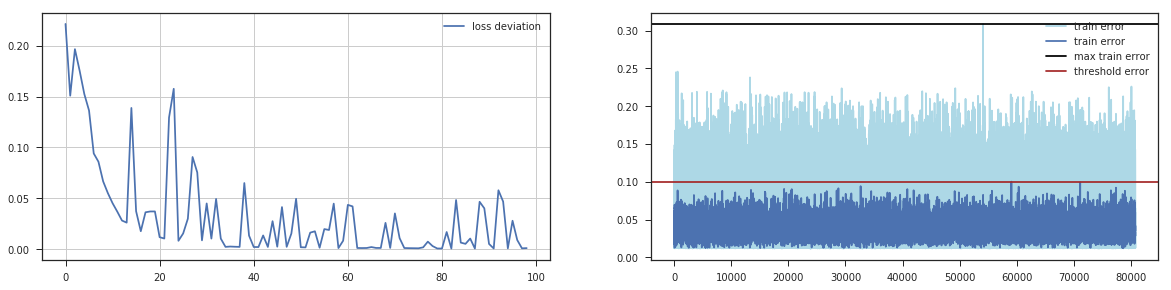

In [18]:
from sklearn.model_selection import train_test_split
train_flows, test_flows = train_test_split(flows_above_threshold, test_size=0.33)

traindata, _features = ds.prepare_data(train_flows, features, flow_modification_f=modify_flow)
autoencoder2, threshold_error2 = train_autoencoder(traindata)

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


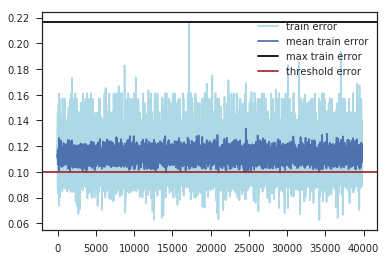

In [19]:
testdata, _features = ds.prepare_data(test_flows, features, flow_modification_f=modify_flow)
scoretrain = autoencoder.score(testdata)
max_scoretrain = max(scoretrain)
    
scoretrain2 = ds.movingaverage(scoretrain, window=10)
#threshold_error2 *= 1.3

plt.plot(scoretrain, color='lightblue', label='train error')
plt.plot(scoretrain2, label='mean train error')
plt.axhline(max_scoretrain, color='black', label='max train error')
plt.axhline(threshold_error2, color='brown', label='threshold error')
plt.legend()
plt.show()

In [20]:
flows_above_threshold2 = [flow for flow, score in zip(test_flows, scoretrain) if score > threshold_error2]
print(len(flows_above_threshold2))

34248


** Use two trained autoencoders for detecting DDoS flows **

In [49]:
def detect_outliers(hdfs, datasets, traffic, features, autoencoder1, autoencoder2, gen_graphs=False):
    start_time = time.time()
    tp_flows, tn_flows, fp_flows, fn_flows = [], [], [], []   
    
    print("Analysing traffic:", traffic)
    
    flows = list(ds.get_flows(hdfs, datasets[traffic]))
    _testdata, _features = ds.prepare_data(flows, features, flow_modification_f=modify_flow)
    _scoretest = autoencoder1.score(_testdata)
    
    _flows_above_threshold = [flow for flow, score in zip(flows, _scoretest) if score > threshold_error]
    
    flows_len, above_len = len(flows), len(_flows_above_threshold)
    print("First AE reduced flow count from %i to %i (%i%%)" % (flows_len, above_len, 100.0*above_len/flows_len))
    
    traindata2, _features = ds.prepare_data(_flows_above_threshold, features, flow_modification_f=modify_flow)
    _scoretest2 = autoencoder2.score(traindata2)
    
    flows_above_threshold = [flow for flow, score in zip(flows, _scoretest2) if score > threshold_error2]
    
    flow_categories, ddos_category, pca_data = cluster2D_and_analyze_flows(flows_above_threshold, features, gen_graphs=True)
    
    print("--- Execution time was %s seconds ---" % (time.time() - start_time))
    
    if len(flows) != len(_testdata):
        print('Different number of element is flows (%i) and _testdata (%i) structures' % (len(flows), len(_testdata)))
    
    ddos = [skip_ddos(flow) for flow in flows]
    ddos_above = [skip_ddos(flow) for flow in _flows_above_threshold]
    
    for index, flow in enumerate(_flows_above_threshold):
        for category, is_ddos in zip(flow_categories, ddos_category):
            if index in category:
                if is_ddos:
                    if ddos_above[index]:
                        tp_flows.append(flows[index])
                    else:
                        fp_flows.append(flows[index])
                else:
                    if ddos[index]:
                        fn_flows.append(flows[index])
                    else:
                        tn_flows.append(flows[index])
                break # index found, no need to seach further

    for index, score in enumerate(_scoretest):
        if score <= threshold_error:
            if ddos[index]:
                pass
            else:
                tn_flows.append(flows[index])
           
    false_positive = len(fp_flows)  # scored as DDoS and is not DDoS
    false_negative = len(fn_flows)  # scored as non-DDoS and is DDoS
    true_positive = len(tp_flows)   # scored as DDoS and is DDoS
    true_negative = len(tn_flows)  # scored as non-DDoS and is not DDoS
    
    ddos_cnt = true_positive + false_negative
    no_ddos_cnt = true_negative + false_positive
    
    # prevent from zero divition exception
    if ddos_cnt == 0: ddos_cnt = 1
    if no_ddos_cnt == 0: no_ddos_cnt = 1
    
    '''
    print("  Flows scored as DDoS and is DDoS: %i (%.2f %%)" % (true_positive, 100.0*true_positive/ddos_cnt))
    print("  Flows scored as non-DDoS and is DDoS: %i (%.2f %%)" % (false_negative, 100.0*false_negative/ddos_cnt))
    print("  Flows scored as non-DDoS and is not DDoS: %i (%.2f %%)" % (true_negative, 100.0*true_negative/no_ddos_cnt))
    print("  Flows scored as DDoS and is not DDoS: %i (%.2f %%)" % (false_positive, 100.0*false_positive/no_ddos_cnt))
    print()
    '''
    
    if gen_graphs:
        plt.figure(figsize=(10,5))
        plt.plot(_scoretest2, color='lightblue')
        plt.plot(ds.movingaverage(_scoretest2, window=10), color='darkblue')
        plt.axhline(threshold_error2, color='brown', label='upper train error')
        plt.title("Test error distribution in %s dataset" % traffic)
        plt.xlabel('flow index')
        plt.ylabel('error')
        plt.show()
    
    print("--- Execution time was %s seconds ---" % (time.time() - start_time))
    
    return {'score': "FP = %.2f%%, FN = %.2f%%" % (100.0*false_positive/no_ddos_cnt, 100.0*false_negative/ddos_cnt),
            'tp_flows': tp_flows,
            'tn_flows': tn_flows,
            'fp_flows': fp_flows,
            'fn_flows': fn_flows,
            'pca_data': pca_data}

Analysing traffic: 0
Skipped flows: 0 from 29168 (0.00%)
First AE reduced flow count from 29168 to 8442 (28%)
Number of flow clustered: 501
PCA 2D dimentions variances: [ 0.54251024  0.16401133]
2
Category id #0 contains 315 flows
Category id #1 contains 169 flows
--- Execution time was 5.804919004440308 seconds ---
--- Execution time was 5.9813947677612305 seconds ---
Analysing traffic: 1
Skipped flows: 0 from 25478 (0.00%)
First AE reduced flow count from 25478 to 6327 (24%)
Number of flow clustered: 614
PCA 2D dimentions variances: [ 0.54251024  0.16401133]
4
Category id #0 contains 387 flows
Category id #1 contains 191 flows
Category id #2 contains 19 flows
Category id #3 contains 10 flows
--- Execution time was 5.456182479858398 seconds ---
--- Execution time was 5.615776062011719 seconds ---
Analysing traffic: 2
Skipped flows: 0 from 28006 (0.00%)
First AE reduced flow count from 28006 to 7041 (25%)
Number of flow clustered: 520
PCA 2D dimentions variances: [ 0.54251024  0.164011

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


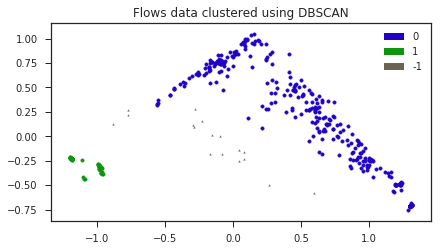

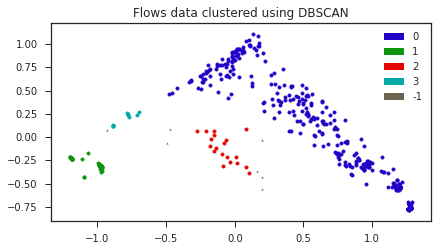

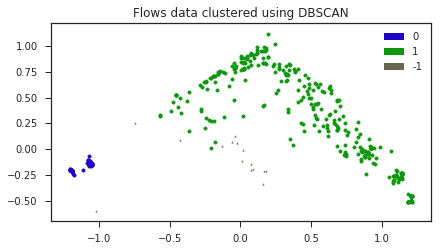

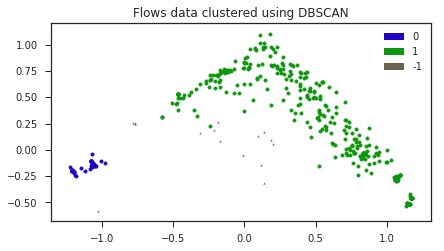

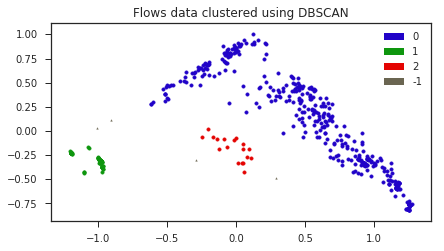

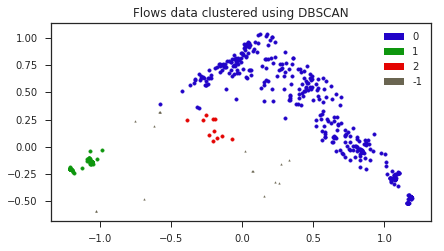

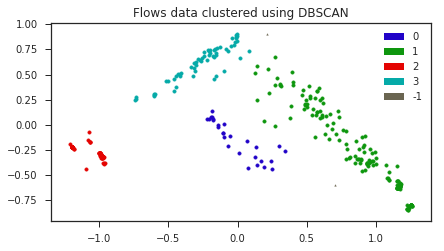

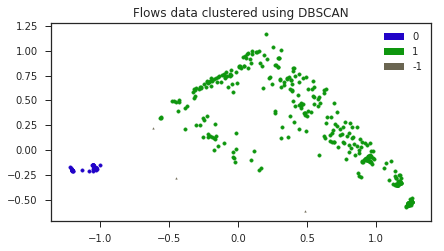

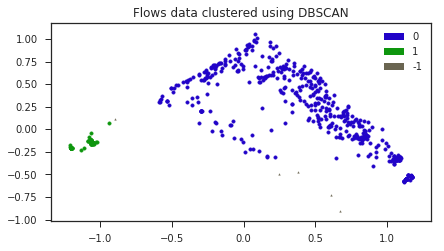

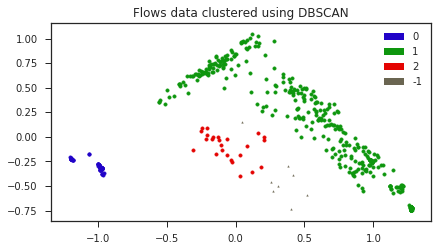

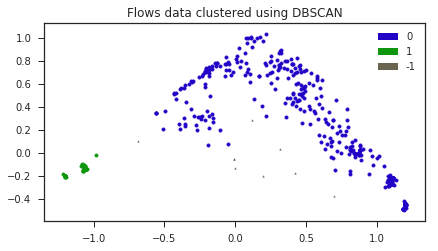

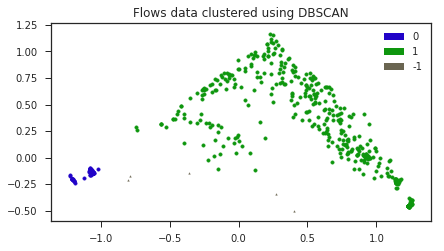

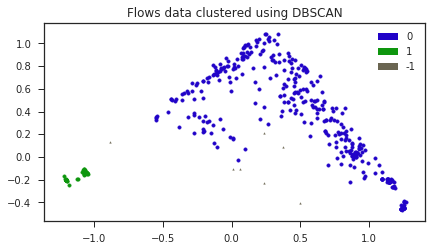

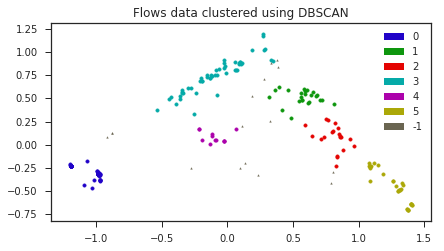

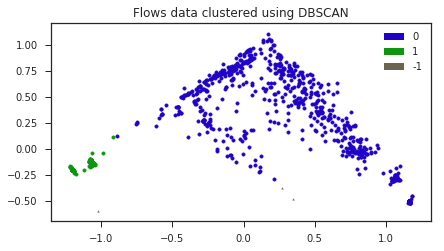

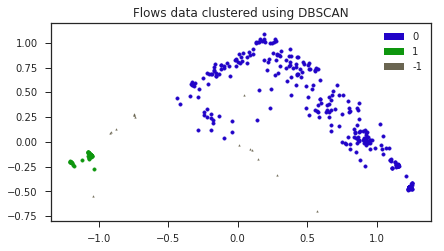

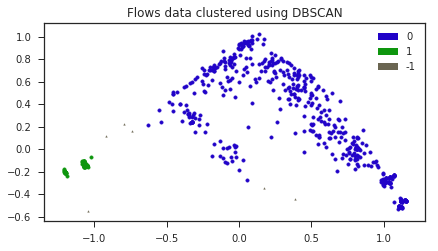

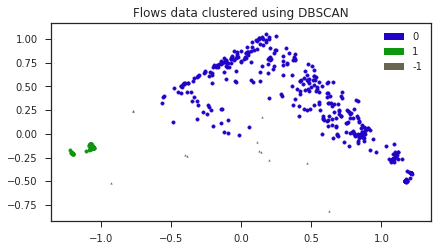

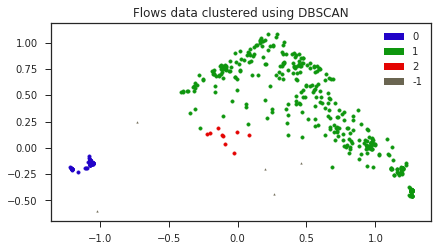

In [67]:
results = {}
above_threshold_data = []
for name, dataset in datasets2.items():
    result = detect_outliers(hdfs, datasets2, name, features, autoencoder, autoencoder2, gen_graphs=False)
    results[name] = result['score']
    above_threshold_data.append(result['pca_data'])

In [115]:
above_threshold_train = np.concatenate(above_threshold_data[:10], axis=0)

from sklearn.ensemble import IsolationForest
from sklearn import svm

isol_forest = IsolationForest(max_samples=len(above_threshold_train), contamination=0.01)
#isol_forest = svm.OneClassSVM()
isol_forest.fit(above_threshold_train)
y_pred_train = isol_forest.predict(above_threshold_train)

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


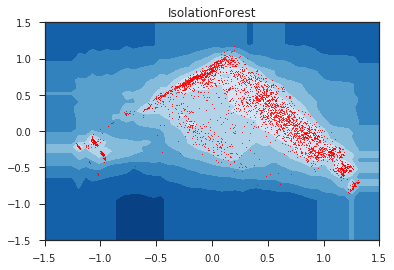

In [116]:
# plot the line, the samples, and the nearest vectors to the plane
border = 1.5
xx, yy = np.meshgrid(np.linspace(-border, border, 50), np.linspace(-border, border, 50))
Z = isol_forest.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.title("IsolationForest")
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
plt.scatter(above_threshold_train[:, 0], above_threshold_train[:, 1], c='red', s=0.5)

In [166]:
def seach_novelities(classifier, data, name):
    data_prediction = classifier.predict(data)
    
    inliners = [d for d, pred in zip(data, data_prediction) if pred == 1]
    outliers = [d for d, pred in zip(data, data_prediction) if pred == -1]
    inliners = np.array(inliners)
    outliers = np.array(outliers)
    
    border = 1.5
    xx, yy = np.meshgrid(np.linspace(-border, border, 50), np.linspace(-border, border, 50))
    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
    plt.scatter(inliners[:, 0], inliners[:, 1], c='red', s=0.5)
    plt.scatter(outliers[:, 0], outliers[:, 1], c='black', s=1.5)
    plt.title(name)
    plt.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


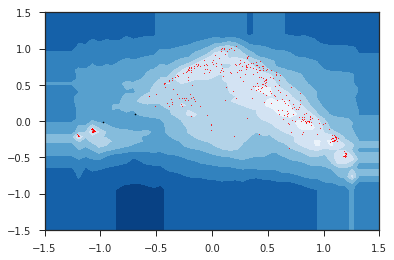

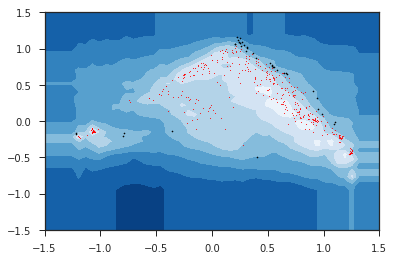

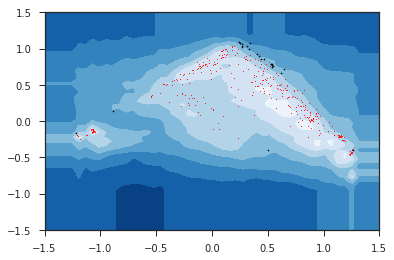

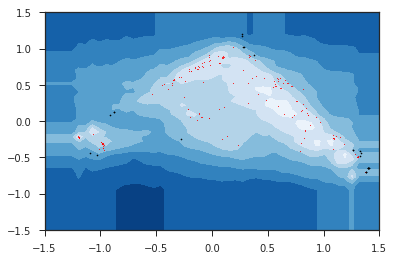

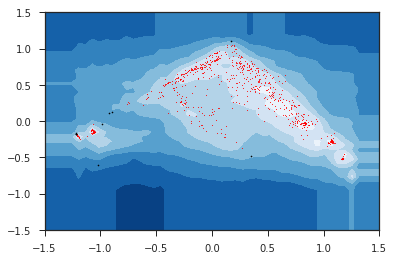

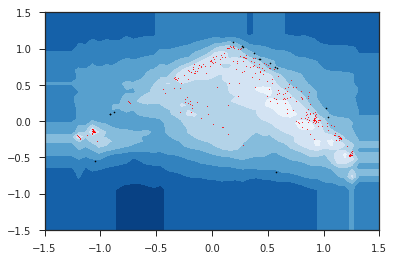

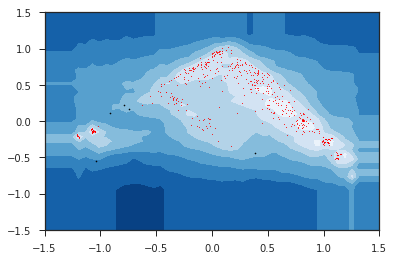

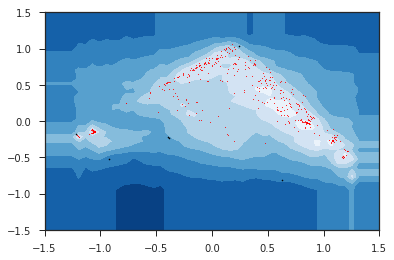

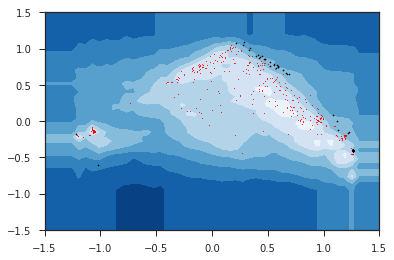

In [118]:
for data in above_threshold_data[10:]:
    seach_novelities(isol_forest, data)

Analysing traffic: Pozman+SYNflood-HTTP
Skipped flows: 0 from 200601 (0.00%)
First AE reduced flow count from 200601 to 178464 (88%)
Number of flow clustered: 172614
PCA 2D dimentions variances: [ 0.54251024  0.16401133]
2
Category id #0 contains 9572 flows
Category id #1 contains 422 flows
--- Execution time was 107.49170303344727 seconds ---
--- Execution time was 131.14517068862915 seconds ---
Analysing traffic: Pozman+RSTflood
Skipped flows: 0 from 196855 (0.00%)
First AE reduced flow count from 196855 to 177974 (90%)
Number of flow clustered: 172810
PCA 2D dimentions variances: [ 0.54251024  0.16401133]
2
Category id #0 contains 9658 flows
Category id #1 contains 337 flows
--- Execution time was 98.08140206336975 seconds ---
--- Execution time was 121.33718633651733 seconds ---
Analysing traffic: Pozman-2
Skipped flows: 0 from 30943 (0.00%)
First AE reduced flow count from 30943 to 7664 (24%)
Number of flow clustered: 711
PCA 2D dimentions variances: [ 0.54251024  0.16401133]
2
Ca

/home/jovyan/work/dataset_utils2.py:342: RuntimeWarning: invalid value encountered in true_divide
  scalled = high - (((high - low) * (maxs - rawpoints)) / rng)  # throws warnings divide by zero


First AE reduced flow count from 24576 to 23672 (96%)
Number of flow clustered: 23672
PCA 2D dimentions variances: [ 0.54251024  0.16401133]
1
Category id #0 contains 10000 flows
--- Execution time was 52.773813247680664 seconds ---
--- Execution time was 55.2535080909729 seconds ---
Analysing traffic: Pozman-7
Skipped flows: 0 from 30417 (0.00%)
First AE reduced flow count from 30417 to 7460 (24%)
Number of flow clustered: 646
PCA 2D dimentions variances: [ 0.54251024  0.16401133]
2
Category id #0 contains 183 flows
Category id #1 contains 461 flows
--- Execution time was 5.734118938446045 seconds ---
--- Execution time was 5.9198572635650635 seconds ---
Analysing traffic: SYNflood-HTTP
Skipped flows: 0 from 172031 (0.00%)


/home/jovyan/work/dataset_utils2.py:342: RuntimeWarning: invalid value encountered in true_divide
  scalled = high - (((high - low) * (maxs - rawpoints)) / rng)  # throws warnings divide by zero


First AE reduced flow count from 172031 to 154451 (89%)
Number of flow clustered: 154451
PCA 2D dimentions variances: [ 0.54251024  0.16401133]
1
Category id #0 contains 10000 flows
--- Execution time was 87.83693623542786 seconds ---
--- Execution time was 107.53642845153809 seconds ---
Analysing traffic: Pozman-1
Skipped flows: 0 from 31857 (0.00%)
First AE reduced flow count from 31857 to 7701 (24%)
Number of flow clustered: 735
PCA 2D dimentions variances: [ 0.54251024  0.16401133]
2
Category id #0 contains 507 flows
Category id #1 contains 219 flows
--- Execution time was 6.248045921325684 seconds ---
--- Execution time was 6.446110963821411 seconds ---
Analysing traffic: Pozman+SYNfloodFIN
Skipped flows: 0 from 200133 (0.00%)
First AE reduced flow count from 200133 to 178290 (89%)
Number of flow clustered: 172667
PCA 2D dimentions variances: [ 0.54251024  0.16401133]
2
Category id #0 contains 9646 flows
Category id #1 contains 347 flows
--- Execution time was 99.0406768321991 sec

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


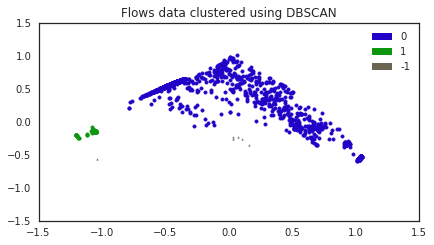

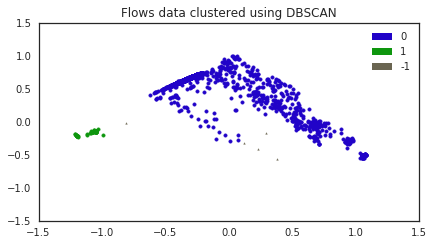

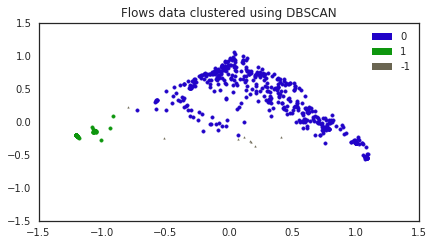

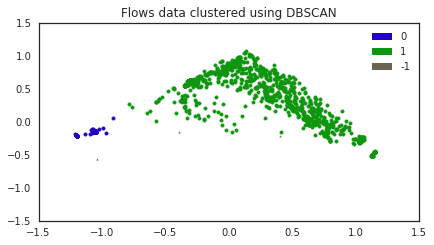

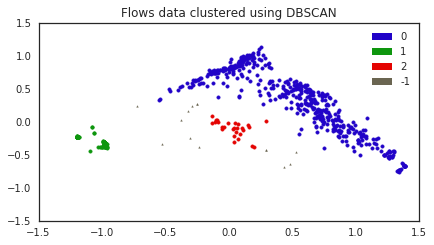

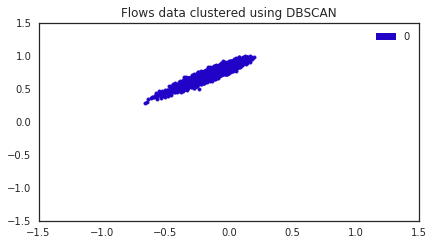

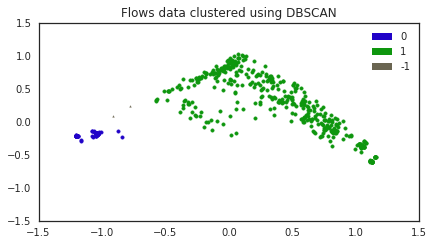

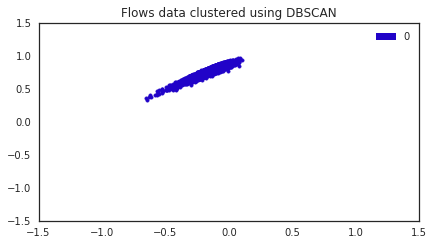

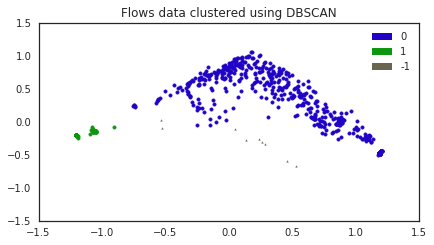

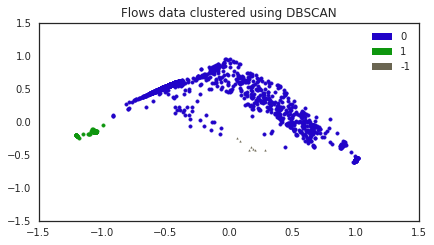

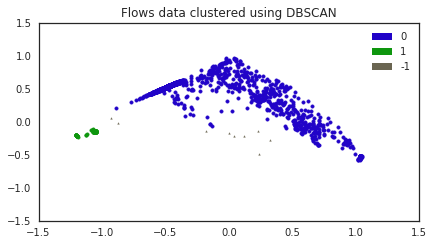

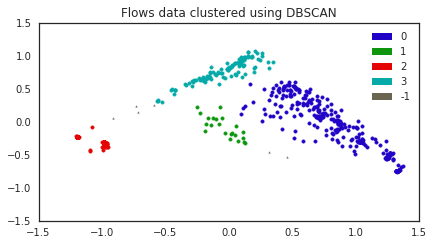

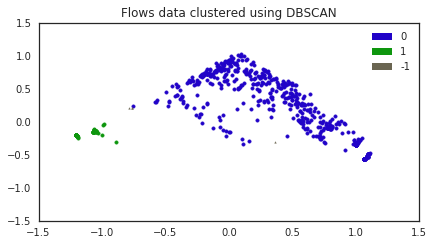

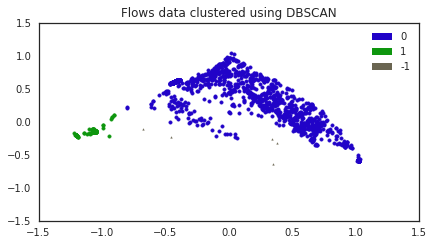

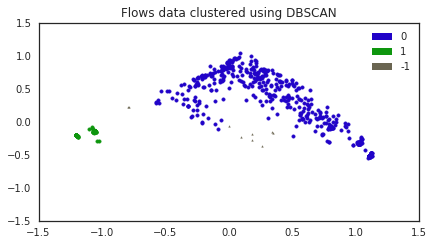

In [163]:
results = {}
above_threshold_data2 = {}
for name, dataset in datasets.items():
    result = detect_outliers(hdfs, datasets, name, features, autoencoder, autoencoder2, gen_graphs=False)
    results[name] = result['score']
    above_threshold_data2[name] = result['pca_data']

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


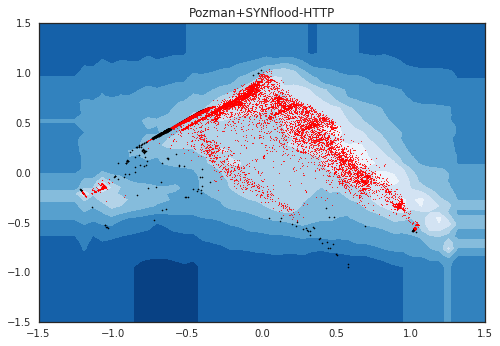

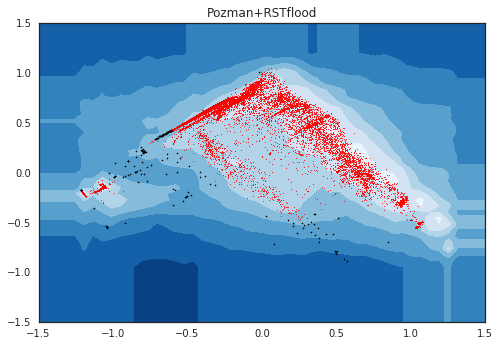

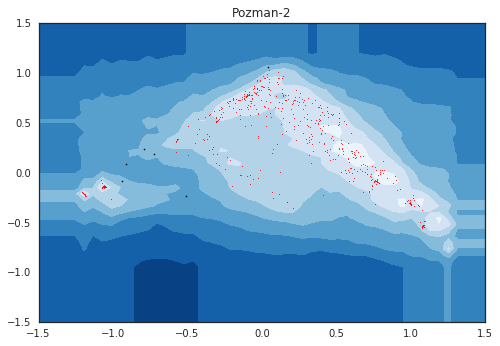

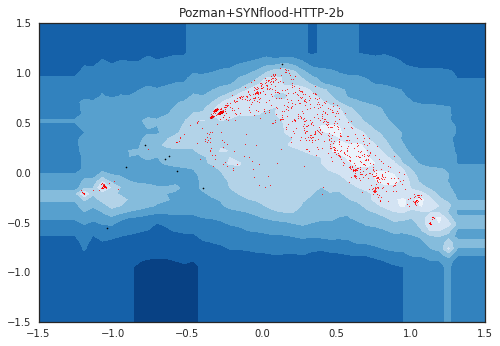

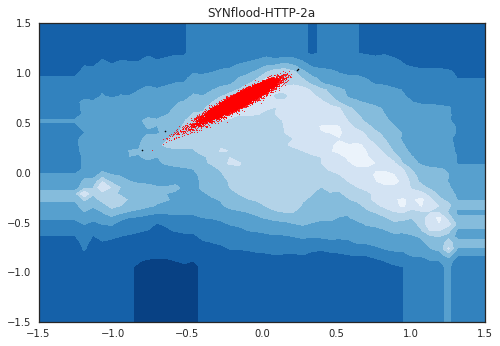

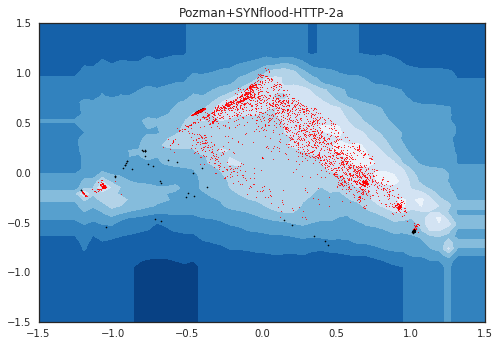

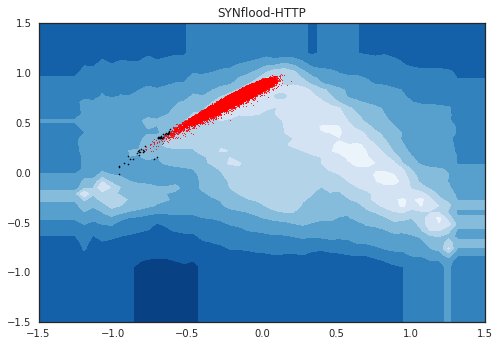

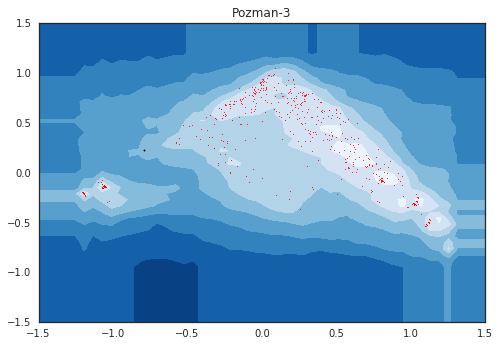

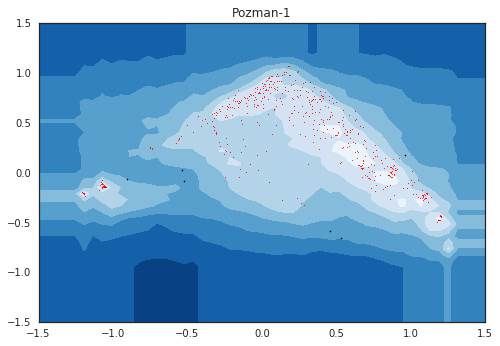

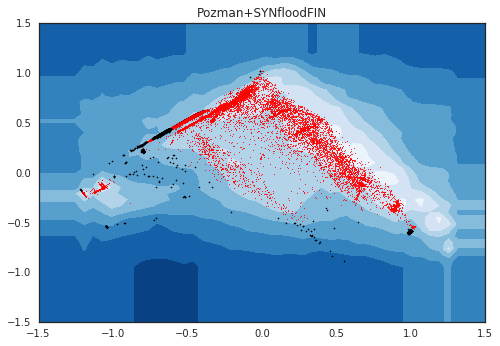

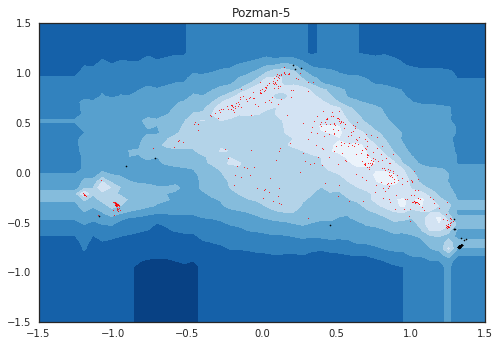

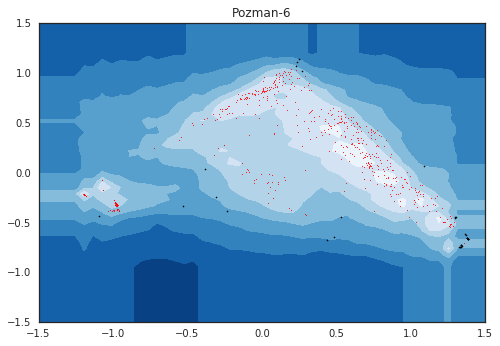

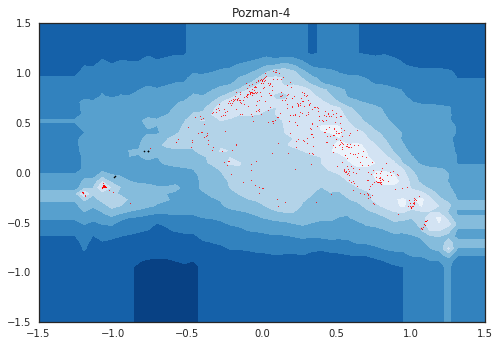

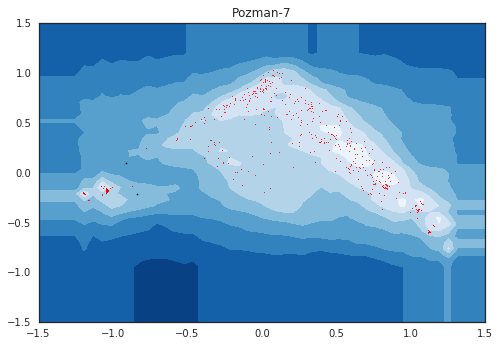

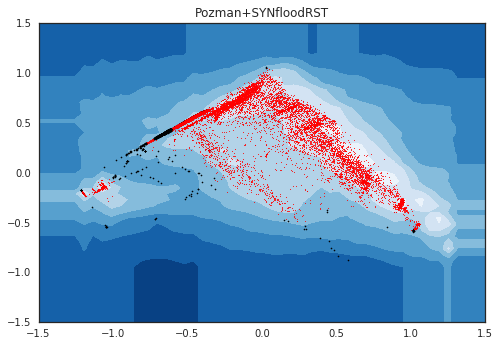

In [167]:
for name, data in above_threshold_data2.items():
    seach_novelities(isol_forest, data, name)

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


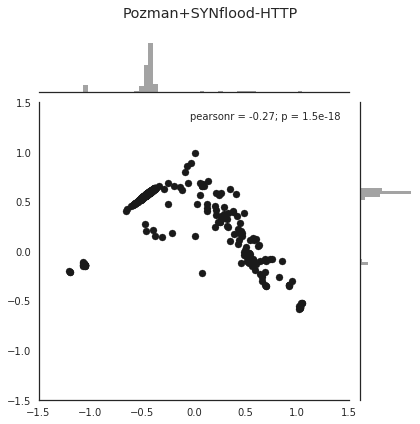

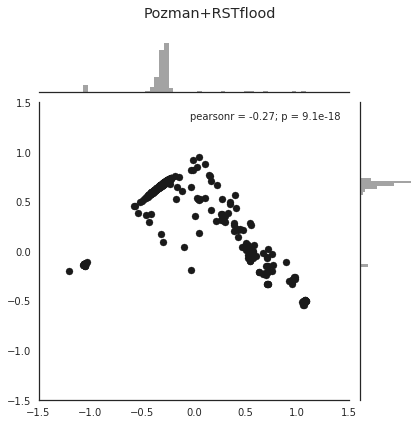

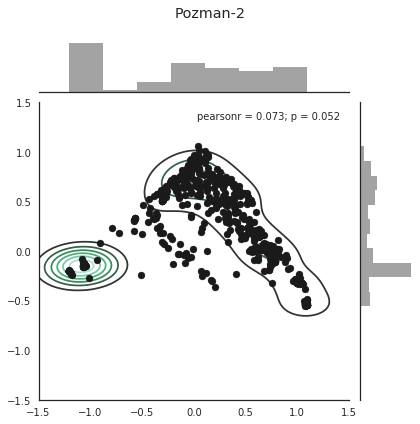

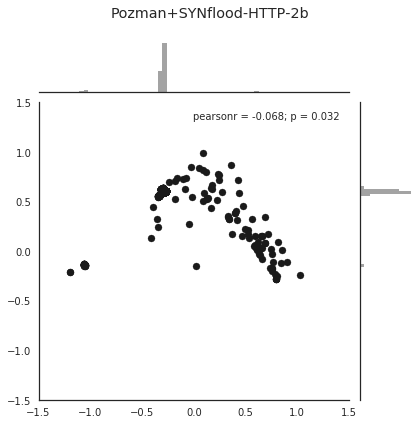

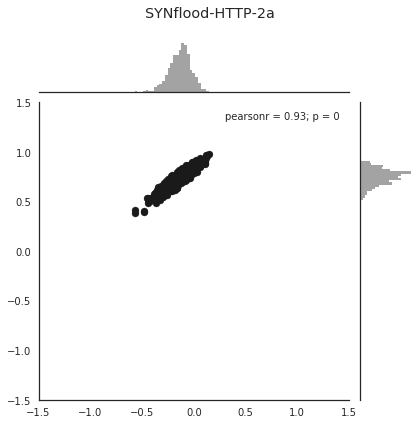

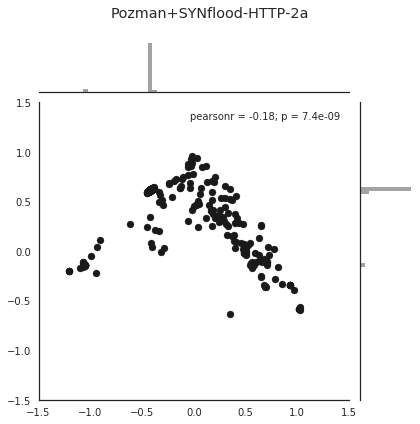

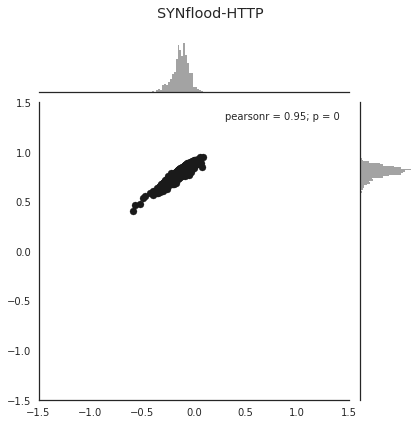

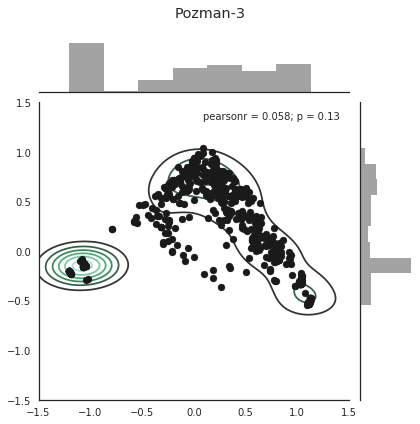

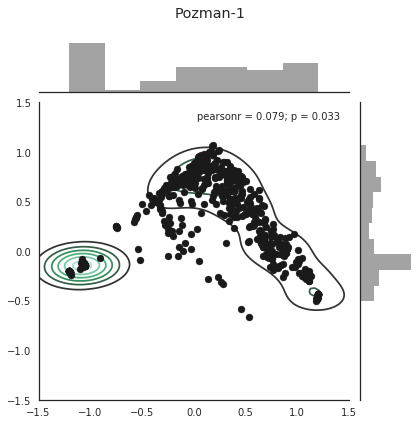

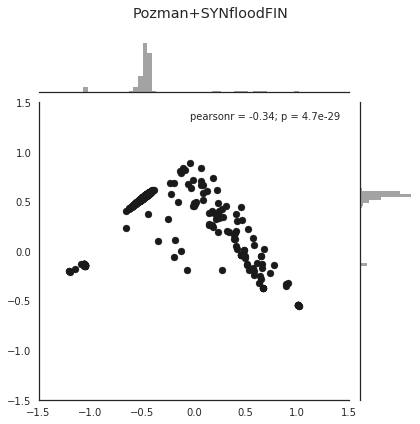

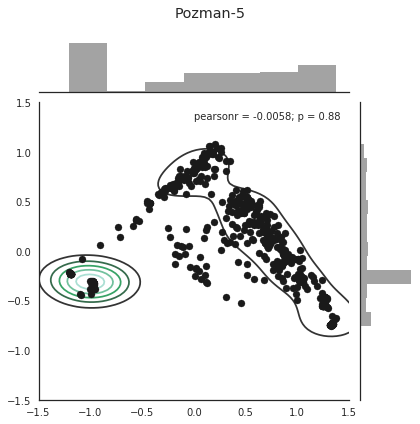

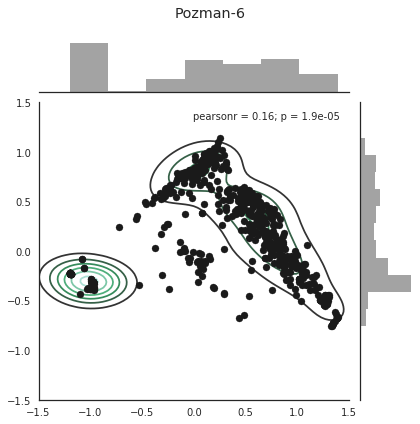

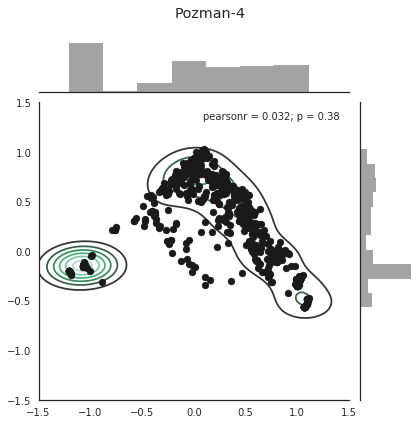

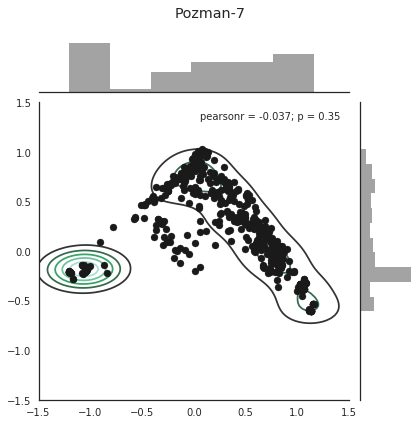

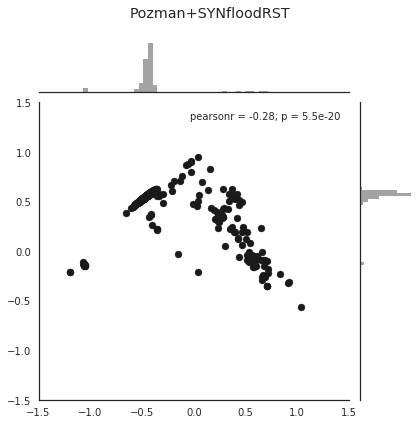

In [231]:
import seaborn as sns; sns.set(style="white", color_codes=True)

for name, data in above_threshold_data2.items():
    sampled_data = data[:1000]
    g = sns.jointplot(sampled_data[:,0], sampled_data[:, 1], color="k",
                     xlim=(-1.5,1.5), ylim=(-1.5,1.5)).plot_joint(sns.kdeplot, zorder=0, n_levels=6)
    plt.subplots_adjust(top=0.9)
    sns.plt.suptitle(name)

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


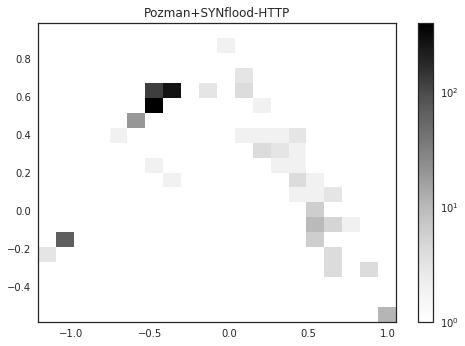

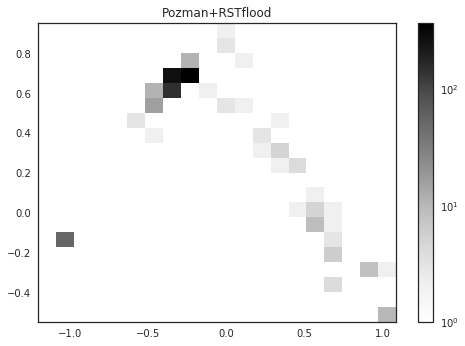

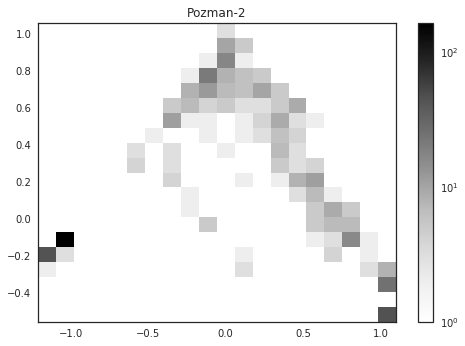

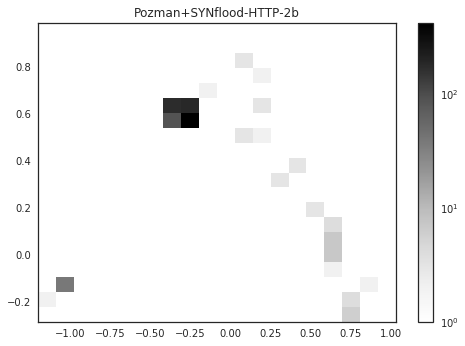

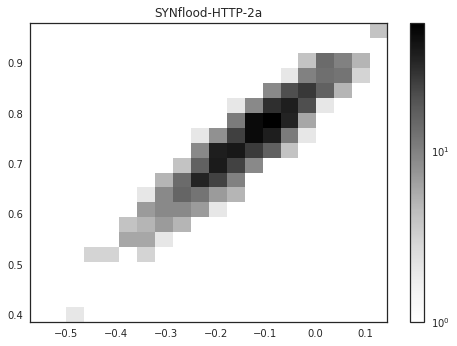

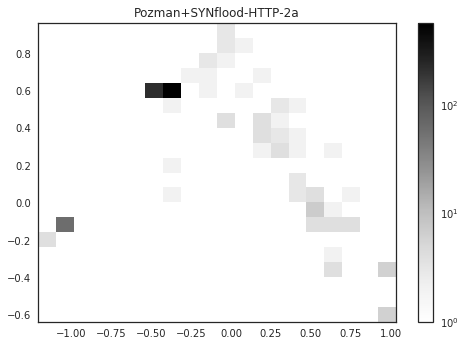

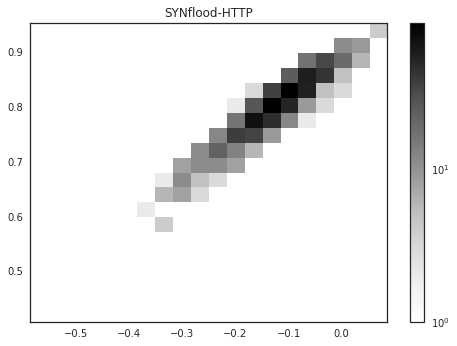

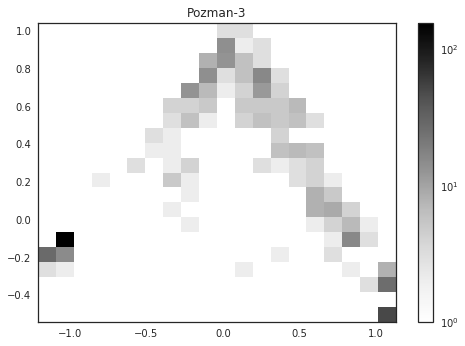

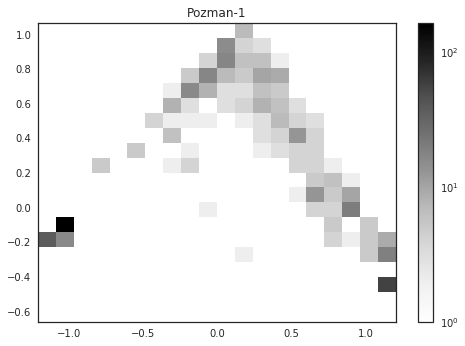

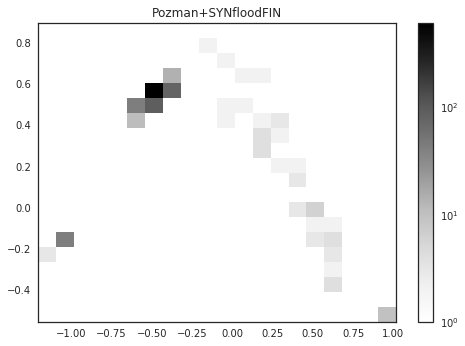

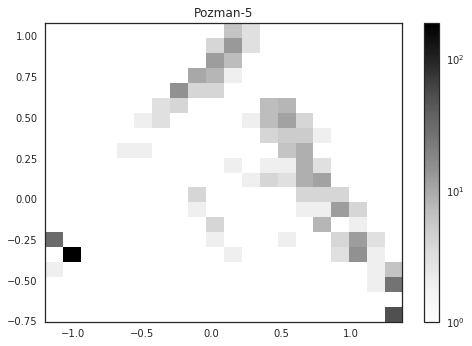

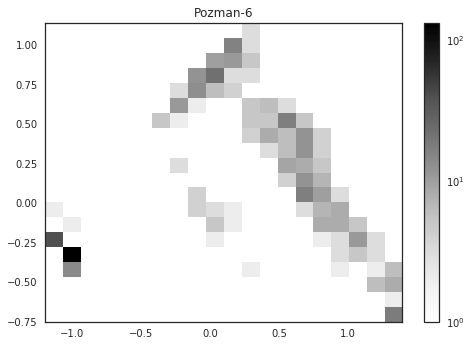

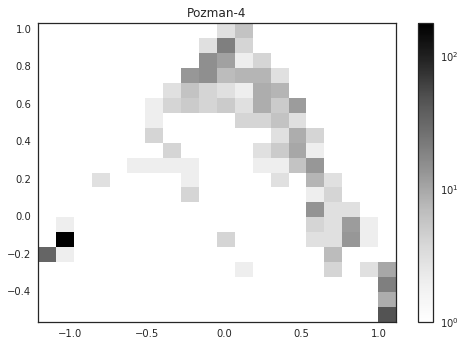

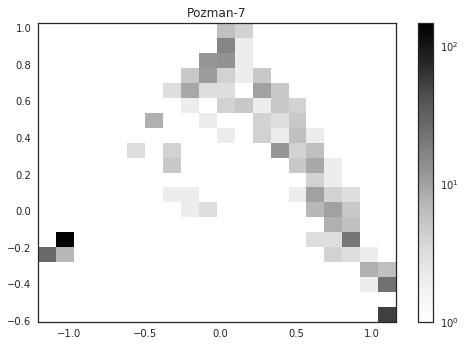

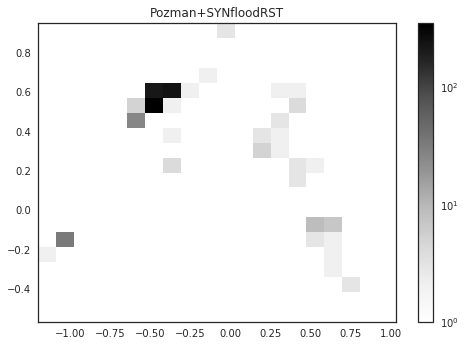

In [257]:
def seach_novelities2(data, name):
    sampled_data = data[:1000]
    hist, xedges, yedges  = np.histogram2d(sampled_data[:,0],sampled_data[:,1],bins=20,normed=True)
    from matplotlib.colors import LogNorm
    plt.hist2d(sampled_data[:,0], sampled_data[:,1], bins=20, norm=LogNorm())
    plt.colorbar()
    plt.title(name)
    plt.show()

for name, data in above_threshold_data2.items():
    seach_novelities2(data, name)